In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras import layers, models, optimizers
from IPython.display import HTML
import keras

In [3]:
BATCH_SIZE = 16
IMAGE_SIZE = (256, 256)

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "data",
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=42,
)

Found 16011 files belonging to 10 classes.


In [4]:
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [5]:
len(dataset)

1001

In [6]:
501*32

16032

In [7]:
# Images to tf dataset
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
    print(image_batch)

(16, 256, 256, 3)
[2 1 7 9 8 2 4 8 7 9 5 5 7 2 4 0]
tf.Tensor(
[[[[186. 178. 175.]
   [188. 180. 177.]
   [190. 182. 179.]
   ...
   [173. 165. 163.]
   [175. 167. 165.]
   [175. 167. 165.]]

  [[194. 186. 183.]
   [195. 187. 184.]
   [196. 188. 185.]
   ...
   [177. 169. 167.]
   [177. 169. 167.]
   [176. 168. 166.]]

  [[188. 180. 177.]
   [190. 182. 179.]
   [192. 184. 181.]
   ...
   [181. 173. 171.]
   [179. 171. 169.]
   [176. 168. 166.]]

  ...

  [[129. 115. 112.]
   [126. 112. 109.]
   [124. 110. 107.]
   ...
   [109.  98.  94.]
   [111. 100.  96.]
   [119. 108. 104.]]

  [[117. 103. 100.]
   [117. 103. 100.]
   [119. 105. 102.]
   ...
   [108.  97.  93.]
   [108.  97.  93.]
   [117. 106. 102.]]

  [[112.  98.  95.]
   [114. 100.  97.]
   [117. 103. 100.]
   ...
   [103.  92.  88.]
   [103.  92.  88.]
   [111. 100.  96.]]]


 [[[129. 117. 117.]
   [148. 136. 136.]
   [141. 129. 129.]
   ...
   [153. 144. 147.]
   [162. 153. 156.]
   [167. 158. 161.]]

  [[138. 126. 126.]
   [1

2024-08-17 08:35:08.497306: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2024-08-17 08:35:08.601988: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


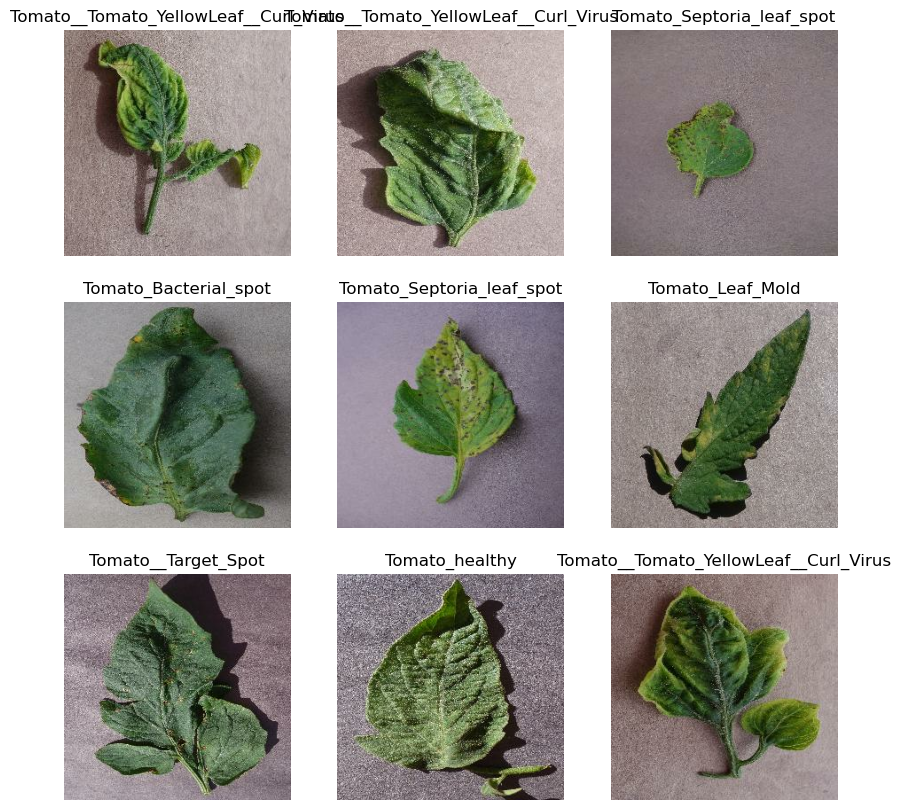

In [8]:
# Visualisation of am iamge from tf dataset
for image_batch, labels_batch in dataset.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [9]:
EPOCHS = 50

In [10]:
# Train test split
# 80% will be training set
# 10% will be validation set
# 10% will be test set

def get_partitioned_datesets(dataset, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=42, reshuffle_each_iteration=False)

    dataset_size = len(dataset)
    train_size = int(train_split * dataset_size)
    train_dataset = dataset.take(train_size)
    dataset = dataset.skip(train_size)

    val_size = int(val_split * dataset_size)
    val_dataset = dataset.take(val_size)
    dataset = dataset.skip(val_size)

    test_size = dataset_size - train_size - val_size
    test_dataset = dataset.take(test_size)

    return train_dataset, val_dataset, test_dataset

In [11]:
train_dataset, val_dataset, test_dataset = get_partitioned_datesets(dataset)

In [12]:
len(train_dataset), len(val_dataset), len(test_dataset)

(800, 100, 101)

In [13]:
train_dataset = train_dataset.shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
#train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
#val_dataset = val_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
#test_dataset = test_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
# Data augmentation
IMAGE_SIZE = 256

#data_augmentation = models.Sequential([
#    #layers.experimental.preprocessing.Rescaling(1./255),
#    #layers.experimental.preprocessing.RandomFlip("horizontal"),
#    #layers.experimental.preprocessing.RandomRotation(0.1),
#    #layers.experimental.preprocessing.RandomZoom(0.1),
#    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
#    layers.Rescaling(1./255),
#])

#data_augmentation(image_batch)

resize_and_rescale = models.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [15]:
#data_augmentation = models.Sequential([
#    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
#    layers.Rescaling(1./255),
#    layers.RandomFlip("horizontal_and_vertical"),
#    layers.RandomRotation(0.2),
#    layers.RandomZoom(0.2),
#    layers.RandomTranslation(0.2, 0.2),
#    layers.RandomContrast(0.2),
#    layers.RandomBrightness(0.2),
#])
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2)
])

In [16]:
CHANNELS = 3
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

# I have deleted two pairs of (2nd Conv2D and MaxPooling2D)

model.build(input_shape=input_shape)

/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (16, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (16, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (16, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (16, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (16, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (16, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (16, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (16, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (16, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (16, 12544)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (16, 64)               │       802,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (16, 10)               │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 896,778 (3.42 MB)

 Trainable params: 896,778 (3.42 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
model.compile(
    optimizer=optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)

In [19]:
history = model.fit(
    train_dataset,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/50


2024-08-17 08:35:23.285017: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 446 of 10000
2024-08-17 08:35:34.295165: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 604 of 10000
2024-08-17 08:35:50.865105: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-08-17 08:35:50.904234: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 1 of 1000
2024-08-17 08:35:51.109144: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.4988 - loss: 1.4223

2024-08-17 08:43:03.022539: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 469 of 10000
2024-08-17 08:43:21.101016: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 968 of 10000
2024-08-17 08:43:22.803744: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 514s 592ms/step - accuracy: 0.4990 - loss: 1.4217 - val_accuracy: 0.8294 - val_loss: 0.4942
Epoch 2/50


2024-08-17 08:43:57.362857: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 594 of 10000
2024-08-17 08:44:07.415283: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 856 of 10000
2024-08-17 08:44:14.863998: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-08-17 08:44:14.977017: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.8464 - loss: 0.4514

2024-08-17 08:50:32.480769: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 508 of 10000
2024-08-17 08:50:42.725572: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 808 of 10000
2024-08-17 08:50:51.232539: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 443s 516ms/step - accuracy: 0.8464 - loss: 0.4514 - val_accuracy: 0.8687 - val_loss: 0.3695
Epoch 3/50


2024-08-17 08:51:20.696967: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 589 of 10000
2024-08-17 08:51:28.935756: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-08-17 08:51:29.205678: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.8961 - loss: 0.3075

2024-08-17 08:57:31.709005: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 593 of 10000
2024-08-17 08:57:42.004795: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 415s 493ms/step - accuracy: 0.8961 - loss: 0.3075 - val_accuracy: 0.8938 - val_loss: 0.2993
Epoch 4/50


2024-08-17 08:58:14.533526: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 716 of 10000
2024-08-17 08:58:22.844026: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-08-17 08:58:23.046989: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.9223 - loss: 0.2253

2024-08-17 09:03:57.586259: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 633 of 10000
2024-08-17 09:04:11.371369: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 390s 461ms/step - accuracy: 0.9223 - loss: 0.2253 - val_accuracy: 0.9337 - val_loss: 0.1889
Epoch 5/50


2024-08-17 09:04:43.832057: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 657 of 10000
2024-08-17 09:04:54.780720: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-08-17 09:04:54.847509: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 1 of 1000
2024-08-17 09:04:55.138565: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.9418 - loss: 0.1645

2024-08-17 09:10:00.925220: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 565 of 10000
2024-08-17 09:10:09.178528: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 359s 421ms/step - accuracy: 0.9418 - loss: 0.1645 - val_accuracy: 0.9162 - val_loss: 0.2475
Epoch 6/50


2024-08-17 09:10:43.652558: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 946 of 10000
2024-08-17 09:10:46.023507: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-08-17 09:10:46.103780: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.9489 - loss: 0.1418

2024-08-17 09:16:20.001809: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 701 of 10000
2024-08-17 09:16:25.479520: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 369s 442ms/step - accuracy: 0.9489 - loss: 0.1418 - val_accuracy: 0.9719 - val_loss: 0.0872
Epoch 7/50


2024-08-17 09:16:51.149386: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 899 of 10000
2024-08-17 09:16:58.030670: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-08-17 09:16:58.202076: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.9636 - loss: 0.1105

2024-08-17 09:22:05.703592: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 939 of 10000
2024-08-17 09:22:06.917501: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 339s 400ms/step - accuracy: 0.9636 - loss: 0.1105 - val_accuracy: 0.9613 - val_loss: 0.1413
Epoch 8/50


2024-08-17 09:22:30.639469: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 881 of 10000
2024-08-17 09:22:35.349488: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-08-17 09:22:35.476155: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9652 - loss: 0.1031

2024-08-17 11:06:01.602475: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 712 of 10000
2024-08-17 11:06:11.666102: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 6247s 8s/step - accuracy: 0.9652 - loss: 0.1031 - val_accuracy: 0.9756 - val_loss: 0.0753
Epoch 9/50


2024-08-17 11:06:37.212586: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 734 of 10000
2024-08-17 11:06:50.451051: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-08-17 11:06:50.467295: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 1 of 1000
2024-08-17 11:06:50.615661: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.9807 - loss: 0.0599

2024-08-17 11:13:01.686858: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 599 of 10000
2024-08-17 11:13:12.497987: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 960 of 10000
2024-08-17 11:13:13.327047: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 427s 503ms/step - accuracy: 0.9807 - loss: 0.0599 - val_accuracy: 0.9212 - val_loss: 0.2416
Epoch 10/50


2024-08-17 11:13:44.578877: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 806 of 10000
2024-08-17 11:13:53.727857: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-08-17 11:13:54.115012: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.9706 - loss: 0.0861

2024-08-17 11:18:50.707040: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 753 of 10000
2024-08-17 11:18:58.734668: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 338s 397ms/step - accuracy: 0.9706 - loss: 0.0861 - val_accuracy: 0.9750 - val_loss: 0.0694
Epoch 11/50


2024-08-17 11:19:22.404440: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 768 of 10000
2024-08-17 11:19:31.824961: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-08-17 11:19:32.004581: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.9803 - loss: 0.0569

2024-08-17 11:24:19.802031: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 761 of 10000
2024-08-17 11:24:26.879347: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 328s 384ms/step - accuracy: 0.9803 - loss: 0.0569 - val_accuracy: 0.9825 - val_loss: 0.0447
Epoch 12/50


2024-08-17 11:24:50.548128: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 809 of 10000
2024-08-17 11:24:58.015149: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-08-17 11:24:58.288846: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.9792 - loss: 0.0591

2024-08-17 11:29:55.719154: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 659 of 10000
2024-08-17 11:30:03.919747: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 338s 398ms/step - accuracy: 0.9792 - loss: 0.0591 - val_accuracy: 0.9737 - val_loss: 0.0756
Epoch 13/50


2024-08-17 11:30:28.222961: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 733 of 10000
2024-08-17 11:30:40.422252: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-08-17 11:30:40.432154: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 1 of 1000
2024-08-17 11:30:40.628113: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.9820 - loss: 0.0553

2024-08-17 11:35:41.944020: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 664 of 10000
2024-08-17 11:35:51.176017: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 349s 406ms/step - accuracy: 0.9820 - loss: 0.0553 - val_accuracy: 0.9769 - val_loss: 0.0632
Epoch 14/50


2024-08-17 11:36:16.819475: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 658 of 10000
2024-08-17 11:36:26.978454: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 944 of 10000
2024-08-17 11:36:28.643141: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-08-17 11:36:28.884317: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.9862 - loss: 0.0444

2024-08-17 11:41:52.097734: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 719 of 10000
2024-08-17 11:41:59.909368: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 367s 431ms/step - accuracy: 0.9861 - loss: 0.0444 - val_accuracy: 0.9881 - val_loss: 0.0481
Epoch 15/50


2024-08-17 11:42:24.065624: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 690 of 10000
2024-08-17 11:42:34.238633: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 1001 of 10000
2024-08-17 11:42:34.287785: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-08-17 11:42:34.420652: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.9839 - loss: 0.0496

2024-08-17 11:48:03.212016: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 584 of 10000
2024-08-17 11:48:14.880218: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 377s 443ms/step - accuracy: 0.9839 - loss: 0.0496 - val_accuracy: 0.9931 - val_loss: 0.0166
Epoch 16/50


2024-08-17 11:48:40.693410: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 678 of 10000
2024-08-17 11:48:50.797901: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 974 of 10000
2024-08-17 11:48:51.392543: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-08-17 11:48:51.675520: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.9775 - loss: 0.0678

2024-08-17 11:53:55.223903: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 706 of 10000
2024-08-17 11:54:05.431348: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 999 of 10000
2024-08-17 11:54:05.569024: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 351s 412ms/step - accuracy: 0.9775 - loss: 0.0678 - val_accuracy: 0.9831 - val_loss: 0.0437
Epoch 17/50


2024-08-17 11:54:32.194630: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 557 of 10000
2024-08-17 11:54:42.165006: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 825 of 10000
2024-08-17 11:54:51.400558: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-08-17 11:54:51.768995: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.9953 - loss: 0.0158

2024-08-17 12:00:08.295927: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 700 of 10000
2024-08-17 12:00:15.288687: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 367s 419ms/step - accuracy: 0.9953 - loss: 0.0158 - val_accuracy: 0.9869 - val_loss: 0.0337
Epoch 18/50


2024-08-17 12:00:38.922709: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 753 of 10000
2024-08-17 12:00:50.029333: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-08-17 12:00:50.044765: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 1 of 1000
2024-08-17 12:00:50.294159: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.9771 - loss: 0.0725

2024-08-17 12:05:35.281606: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 657 of 10000
2024-08-17 12:05:45.161453: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 331s 385ms/step - accuracy: 0.9771 - loss: 0.0725 - val_accuracy: 0.9937 - val_loss: 0.0160
Epoch 19/50


2024-08-17 12:06:09.506588: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 728 of 10000
2024-08-17 12:06:22.162540: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-08-17 12:06:22.233650: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 1 of 1000
2024-08-17 12:06:22.572808: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.9878 - loss: 0.0413

2024-08-17 12:11:16.956608: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 638 of 10000
2024-08-17 12:11:25.173296: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 340s 395ms/step - accuracy: 0.9878 - loss: 0.0413 - val_accuracy: 0.9900 - val_loss: 0.0325
Epoch 20/50


2024-08-17 12:11:49.709120: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 748 of 10000
2024-08-17 12:12:03.881983: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-08-17 12:12:03.983139: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 1 of 1000
2024-08-17 12:12:04.202589: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.9936 - loss: 0.0202

2024-08-17 12:17:32.029070: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 680 of 10000
2024-08-17 12:17:41.282564: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 376s 437ms/step - accuracy: 0.9936 - loss: 0.0202 - val_accuracy: 0.9837 - val_loss: 0.0515
Epoch 21/50


2024-08-17 12:18:06.177409: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 652 of 10000
2024-08-17 12:18:20.284765: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-08-17 12:18:20.307705: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 1 of 1000
2024-08-17 12:18:20.465054: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9874 - loss: 0.0369

2024-08-17 12:23:26.173627: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 705 of 10000
2024-08-17 12:23:35.460753: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 354s 409ms/step - accuracy: 0.9874 - loss: 0.0369 - val_accuracy: 0.9956 - val_loss: 0.0128
Epoch 22/50


2024-08-17 12:23:59.228917: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 784 of 10000
2024-08-17 12:24:07.203436: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-08-17 12:24:07.495520: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.9931 - loss: 0.0206

2024-08-17 12:29:08.874013: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 627 of 10000
2024-08-17 12:29:18.922530: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 908 of 10000
2024-08-17 12:29:21.692532: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 347s 410ms/step - accuracy: 0.9931 - loss: 0.0206 - val_accuracy: 0.9819 - val_loss: 0.0524
Epoch 23/50


2024-08-17 12:29:46.527926: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 642 of 10000
2024-08-17 12:29:56.579955: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 906 of 10000
2024-08-17 12:30:00.698738: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-08-17 12:30:00.831609: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.9894 - loss: 0.0324

2024-08-17 12:35:22.674284: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 697 of 10000
2024-08-17 12:35:32.580265: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 376s 438ms/step - accuracy: 0.9894 - loss: 0.0324 - val_accuracy: 0.9931 - val_loss: 0.0166
Epoch 24/50


2024-08-17 12:36:02.637376: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 595 of 10000
2024-08-17 12:36:12.649131: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 832 of 10000
2024-08-17 12:36:15.992389: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-08-17 12:36:16.264584: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.9843 - loss: 0.0462

2024-08-17 12:42:02.602012: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 590 of 10000
2024-08-17 12:42:13.320244: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 396s 464ms/step - accuracy: 0.9843 - loss: 0.0462 - val_accuracy: 0.9912 - val_loss: 0.0226
Epoch 25/50


2024-08-17 12:42:38.599430: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 580 of 10000
2024-08-17 12:42:48.633280: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 811 of 10000
2024-08-17 12:42:57.057869: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-08-17 12:42:57.345198: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.9919 - loss: 0.0272

2024-08-17 12:49:05.843511: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 495 of 10000
2024-08-17 12:49:21.877555: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 430s 499ms/step - accuracy: 0.9919 - loss: 0.0272 - val_accuracy: 0.9937 - val_loss: 0.0192
Epoch 26/50


2024-08-17 12:49:48.524527: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 483 of 10000
2024-08-17 12:50:08.602503: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 968 of 10000
2024-08-17 12:50:11.057233: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-08-17 12:50:11.443044: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.9859 - loss: 0.0466

2024-08-17 12:56:06.949631: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 496 of 10000
2024-08-17 12:56:16.944601: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 886 of 10000
2024-08-17 12:56:19.530469: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 421s 483ms/step - accuracy: 0.9859 - loss: 0.0466 - val_accuracy: 0.9906 - val_loss: 0.0252
Epoch 27/50


2024-08-17 12:56:48.899246: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 720 of 10000
2024-08-17 12:56:58.427115: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-08-17 12:56:58.849000: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.9908 - loss: 0.0248

2024-08-17 13:02:41.466354: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 495 of 10000
2024-08-17 13:02:56.482862: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 393s 465ms/step - accuracy: 0.9908 - loss: 0.0248 - val_accuracy: 0.9513 - val_loss: 0.2062
Epoch 28/50


2024-08-17 13:03:21.820602: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 561 of 10000
2024-08-17 13:03:38.968654: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-08-17 13:03:38.993746: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 1 of 1000
2024-08-17 13:03:39.142562: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.9871 - loss: 0.0423

2024-08-17 13:08:59.455874: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 571 of 10000
2024-08-17 13:09:12.023663: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 374s 432ms/step - accuracy: 0.9871 - loss: 0.0423 - val_accuracy: 0.9837 - val_loss: 0.0568
Epoch 29/50


2024-08-17 13:09:35.810218: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 714 of 10000
2024-08-17 13:09:46.375232: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-08-17 13:09:46.385409: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 1 of 1000
2024-08-17 13:09:46.636946: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.9871 - loss: 0.0460

2024-08-17 13:15:02.699843: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 547 of 10000
2024-08-17 13:15:16.001494: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 365s 429ms/step - accuracy: 0.9871 - loss: 0.0460 - val_accuracy: 0.9906 - val_loss: 0.0361
Epoch 30/50


2024-08-17 13:15:40.567551: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 622 of 10000
2024-08-17 13:15:50.663899: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 859 of 10000
2024-08-17 13:15:56.364307: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-08-17 13:15:56.656696: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.9935 - loss: 0.0216

2024-08-17 13:21:15.253700: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 618 of 10000
2024-08-17 13:21:25.077906: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 371s 430ms/step - accuracy: 0.9935 - loss: 0.0216 - val_accuracy: 0.9987 - val_loss: 0.0014
Epoch 31/50


2024-08-17 13:21:51.485892: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 566 of 10000
2024-08-17 13:22:06.610820: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-08-17 13:22:06.641510: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 1 of 1000
2024-08-17 13:22:06.748487: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.9926 - loss: 0.0286

2024-08-17 13:27:43.541396: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 493 of 10000
2024-08-17 13:27:53.579165: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 791 of 10000
2024-08-17 13:28:00.811667: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 396s 462ms/step - accuracy: 0.9926 - loss: 0.0287 - val_accuracy: 0.9944 - val_loss: 0.0140
Epoch 32/50


2024-08-17 13:28:27.725029: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 508 of 10000
2024-08-17 13:28:40.196195: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-08-17 13:28:40.217935: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 1 of 1000
2024-08-17 13:28:40.460851: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.9963 - loss: 0.0100

2024-08-17 13:34:28.047584: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 586 of 10000
2024-08-17 13:34:44.450724: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 412s 485ms/step - accuracy: 0.9963 - loss: 0.0100 - val_accuracy: 1.0000 - val_loss: 0.0026
Epoch 33/50


2024-08-17 13:35:19.510928: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 714 of 10000
2024-08-17 13:35:29.849758: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 988 of 10000
2024-08-17 13:35:30.600201: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-08-17 13:35:30.971221: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.9948 - loss: 0.0212

2024-08-17 13:40:56.641441: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 602 of 10000
2024-08-17 13:41:07.647665: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 373s 436ms/step - accuracy: 0.9948 - loss: 0.0212 - val_accuracy: 0.9994 - val_loss: 0.0038
Epoch 34/50


2024-08-17 13:41:32.107103: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 712 of 10000
2024-08-17 13:41:43.090698: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-08-17 13:41:43.140351: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 1 of 1000
2024-08-17 13:41:43.272493: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.9926 - loss: 0.0231

2024-08-17 13:47:03.056675: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 641 of 10000
2024-08-17 13:47:13.351262: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 978 of 10000
2024-08-17 13:47:13.559127: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 367s 431ms/step - accuracy: 0.9926 - loss: 0.0232 - val_accuracy: 0.9975 - val_loss: 0.0105
Epoch 35/50


2024-08-17 13:47:39.735792: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 539 of 10000
2024-08-17 13:47:56.825559: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-08-17 13:47:56.918351: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 1 of 1000
2024-08-17 13:47:57.163506: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.9896 - loss: 0.0319

2024-08-17 13:53:09.709907: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 694 of 10000
2024-08-17 13:53:16.908627: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 363s 417ms/step - accuracy: 0.9896 - loss: 0.0319 - val_accuracy: 0.9656 - val_loss: 0.0945
Epoch 36/50


2024-08-17 13:53:41.957882: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 657 of 10000
2024-08-17 13:53:52.103762: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 949 of 10000
2024-08-17 13:53:54.961316: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-08-17 13:53:55.162496: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.9896 - loss: 0.0349

2024-08-17 13:59:04.364651: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 647 of 10000
2024-08-17 13:59:14.259183: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 359s 418ms/step - accuracy: 0.9896 - loss: 0.0349 - val_accuracy: 0.9994 - val_loss: 0.0029
Epoch 37/50


2024-08-17 13:59:41.063421: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 566 of 10000
2024-08-17 13:59:51.991731: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 780 of 10000
2024-08-17 13:59:57.303168: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-08-17 13:59:57.399793: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.9918 - loss: 0.0286

2024-08-17 14:05:16.173519: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 634 of 10000
2024-08-17 14:05:24.931919: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 371s 430ms/step - accuracy: 0.9918 - loss: 0.0286 - val_accuracy: 0.9969 - val_loss: 0.0081
Epoch 38/50


2024-08-17 14:05:52.255107: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 568 of 10000
2024-08-17 14:06:02.321265: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 827 of 10000
2024-08-17 14:06:12.439252: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-08-17 14:06:12.491359: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 1 of 1000
2024-08-17 14:06:12.703627: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.9966 - loss: 0.0109

2024-08-17 14:11:22.664561: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 670 of 10000
2024-08-17 14:11:32.867345: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 929 of 10000
2024-08-17 14:11:33.891972: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 366s 418ms/step - accuracy: 0.9966 - loss: 0.0109 - val_accuracy: 0.9825 - val_loss: 0.0552
Epoch 39/50


2024-08-17 14:11:57.805265: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 663 of 10000
2024-08-17 14:12:09.896102: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-08-17 14:12:09.970202: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 1 of 1000
2024-08-17 14:12:10.248514: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.9903 - loss: 0.0292

2024-08-17 14:17:08.035286: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 761 of 10000
2024-08-17 14:17:14.544448: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 341s 396ms/step - accuracy: 0.9903 - loss: 0.0292 - val_accuracy: 0.9969 - val_loss: 0.0078
Epoch 40/50


2024-08-17 14:17:38.888862: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 691 of 10000
2024-08-17 14:17:48.938106: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 877 of 10000
2024-08-17 14:17:52.096787: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-08-17 14:17:52.359519: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.9864 - loss: 0.0510

2024-08-17 14:22:47.852605: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 720 of 10000
2024-08-17 14:22:54.403084: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 339s 394ms/step - accuracy: 0.9864 - loss: 0.0509 - val_accuracy: 0.9894 - val_loss: 0.0421
Epoch 41/50


2024-08-17 14:23:18.285790: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 686 of 10000
2024-08-17 14:23:29.974300: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-08-17 14:23:30.073902: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 1 of 1000
2024-08-17 14:23:30.300999: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.9988 - loss: 0.0036

2024-08-17 14:29:29.987547: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 486 of 10000
2024-08-17 14:29:40.640274: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 738 of 10000
2024-08-17 14:29:48.753381: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 419s 495ms/step - accuracy: 0.9988 - loss: 0.0036 - val_accuracy: 0.9869 - val_loss: 0.0422
Epoch 42/50


2024-08-17 14:30:17.698376: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 480 of 10000
2024-08-17 14:30:36.978081: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 993 of 10000
2024-08-17 14:30:37.097898: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-08-17 14:30:37.325116: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.9896 - loss: 0.0425

2024-08-17 14:35:47.437996: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 631 of 10000
2024-08-17 14:35:57.009897: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 365s 416ms/step - accuracy: 0.9896 - loss: 0.0425 - val_accuracy: 0.9925 - val_loss: 0.0261
Epoch 43/50


2024-08-17 14:36:21.880781: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 664 of 10000
2024-08-17 14:36:31.781007: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 934 of 10000
2024-08-17 14:36:33.831383: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-08-17 14:36:34.217665: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9904 - loss: 0.0360

2024-08-17 14:41:40.407597: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 606 of 10000
2024-08-17 14:41:50.790345: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 353s 412ms/step - accuracy: 0.9904 - loss: 0.0360 - val_accuracy: 0.9969 - val_loss: 0.0075
Epoch 44/50


2024-08-17 14:42:15.317480: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 670 of 10000
2024-08-17 14:42:28.137618: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-08-17 14:42:28.185477: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 1 of 1000
2024-08-17 14:42:28.320675: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.9974 - loss: 0.0080

2024-08-17 14:48:07.706275: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 555 of 10000
2024-08-17 14:48:18.293344: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 389s 456ms/step - accuracy: 0.9974 - loss: 0.0080 - val_accuracy: 0.9950 - val_loss: 0.0170
Epoch 45/50


2024-08-17 14:48:43.879319: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 634 of 10000
2024-08-17 14:48:53.937449: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 856 of 10000
2024-08-17 14:48:58.766798: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-08-17 14:48:59.108564: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.9965 - loss: 0.0107

2024-08-17 14:54:22.801627: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 572 of 10000
2024-08-17 14:54:32.854224: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 847 of 10000
2024-08-17 14:54:34.891715: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 376s 437ms/step - accuracy: 0.9965 - loss: 0.0108 - val_accuracy: 0.9981 - val_loss: 0.0074
Epoch 46/50


2024-08-17 14:54:59.593259: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 663 of 10000
2024-08-17 14:55:09.789770: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 966 of 10000
2024-08-17 14:55:10.680976: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-08-17 14:55:10.939754: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.9894 - loss: 0.0437

2024-08-17 15:00:34.431558: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 637 of 10000
2024-08-17 15:00:46.775799: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 373s 439ms/step - accuracy: 0.9894 - loss: 0.0437 - val_accuracy: 0.9994 - val_loss: 0.0013
Epoch 47/50


2024-08-17 15:01:13.055928: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 752 of 10000
2024-08-17 15:01:22.560963: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-08-17 15:01:22.962193: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.9932 - loss: 0.0214

2024-08-17 15:06:37.676773: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 719 of 10000
2024-08-17 15:06:46.779795: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 362s 426ms/step - accuracy: 0.9932 - loss: 0.0214 - val_accuracy: 0.9937 - val_loss: 0.0174
Epoch 48/50


2024-08-17 15:07:14.710948: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 544 of 10000
2024-08-17 15:07:27.979680: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-08-17 15:07:28.079907: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 1 of 1000
2024-08-17 15:07:28.404803: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - accuracy: 0.9893 - loss: 0.0359

2024-08-17 15:14:16.219963: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 455 of 10000
2024-08-17 15:14:26.287454: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 767 of 10000
2024-08-17 15:14:33.987951: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 467s 552ms/step - accuracy: 0.9893 - loss: 0.0359 - val_accuracy: 0.9994 - val_loss: 0.0053
Epoch 49/50


2024-08-17 15:15:01.345800: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 556 of 10000
2024-08-17 15:15:11.794037: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 831 of 10000
2024-08-17 15:15:17.435469: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-08-17 15:15:17.562513: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.9938 - loss: 0.0271

2024-08-17 15:21:23.027187: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 567 of 10000
2024-08-17 15:21:33.183759: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 927 of 10000
2024-08-17 15:21:35.541882: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 418s 487ms/step - accuracy: 0.9937 - loss: 0.0271 - val_accuracy: 0.9981 - val_loss: 0.0070
Epoch 50/50


2024-08-17 15:21:59.560643: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 612 of 10000
2024-08-17 15:22:13.405715: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-08-17 15:22:13.469964: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 1 of 1000
2024-08-17 15:22:13.723642: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.9968 - loss: 0.0091

2024-08-17 15:28:18.967826: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 516 of 10000
2024-08-17 15:28:34.483699: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 420s 494ms/step - accuracy: 0.9968 - loss: 0.0091 - val_accuracy: 0.9962 - val_loss: 0.0082


In [20]:
model.evaluate(test_dataset)

2024-08-17 15:29:00.282506: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 550 of 10000
2024-08-17 15:29:10.839508: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 747 of 10000
2024-08-17 15:29:22.108548: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


101/101 ━━━━━━━━━━━━━━━━━━━━ 50s 160ms/step - accuracy: 0.9965 - loss: 0.0081


[0.008329869247972965, 0.9962871074676514]

In [21]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 800}

In [22]:
# After long 50 epochs I could achieve 0.996 accuracy on test set which is amazing
for image_batch, labels_batch in test_dataset.take(1):
    print(image_batch[0])

2024-08-17 15:45:28.972827: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 507 of 10000
2024-08-17 15:45:39.059271: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 766 of 10000
2024-08-17 15:45:47.023023: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


tf.Tensor(
[[[114. 105. 100.]
  [118. 109. 104.]
  [118. 109. 104.]
  ...
  [160. 155. 151.]
  [157. 152. 148.]
  [140. 135. 131.]]

 [[120. 111. 106.]
  [125. 116. 111.]
  [128. 119. 114.]
  ...
  [159. 154. 150.]
  [159. 154. 150.]
  [146. 141. 137.]]

 [[121. 112. 107.]
  [127. 118. 113.]
  [131. 122. 117.]
  ...
  [157. 152. 148.]
  [165. 160. 156.]
  [159. 154. 150.]]

 ...

 [[130. 124. 126.]
  [126. 120. 122.]
  [128. 122. 124.]
  ...
  [149. 144. 148.]
  [148. 143. 147.]
  [149. 144. 148.]]

 [[126. 120. 122.]
  [124. 118. 120.]
  [128. 122. 124.]
  ...
  [144. 139. 143.]
  [140. 135. 139.]
  [140. 135. 139.]]

 [[125. 119. 121.]
  [125. 119. 121.]
  [130. 124. 126.]
  ...
  [146. 141. 145.]
  [143. 138. 142.]
  [143. 138. 142.]]], shape=(256, 256, 3), dtype=float32)


2024-08-17 15:45:48.205648: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2024-08-17 15:50:10.902128: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 533 of 10000
2024-08-17 15:50:27.847232: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


The first image:
The first image actual label: Tomato_Septoria_leaf_spot
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step
The first image predicted label: Tomato_Septoria_leaf_spot


2024-08-17 15:50:30.825883: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


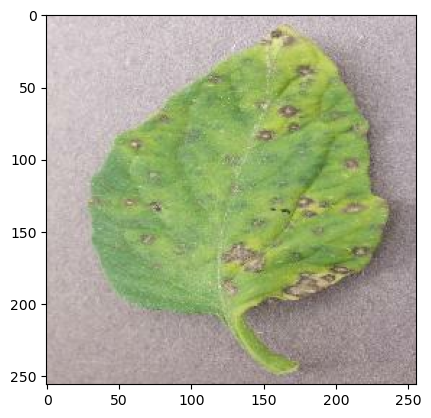

In [23]:
for image_batch, labels_batch in test_dataset.take(1):
    first_image = image_batch[0].numpy().astype("uint8")
    first_label = labels_batch[0]

    print('The first image:')
    plt.imshow(first_image)
    print('The first image actual label:', class_names[first_label])

    batch_predictions = model.predict(image_batch)
    print('The first image predicted label:', class_names[np.argmax(batch_predictions[0])])

2024-08-17 15:52:55.781637: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 601 of 10000
2024-08-17 15:53:05.866006: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 889 of 10000
2024-08-17 15:53:09.909110: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


The first image:
The first image actual label: Tomato__Tomato_YellowLeaf__Curl_Virus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
The first image predicted label: Tomato__Tomato_YellowLeaf__Curl_Virus


2024-08-17 15:53:11.835887: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


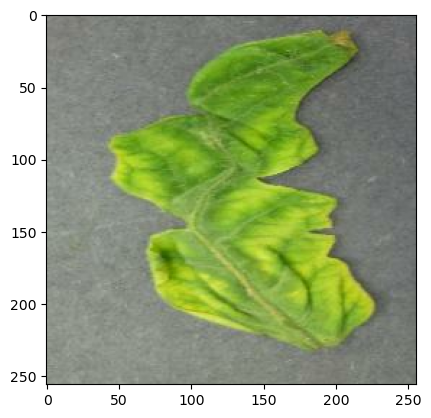

In [24]:
for image_batch, labels_batch in test_dataset.take(1):
    first_image = image_batch[1].numpy().astype("uint8")
    first_label = labels_batch[1]

    print('The first image:')
    plt.imshow(first_image)
    print('The first image actual label:', class_names[first_label])

    batch_predictions = model.predict(image_batch)
    print('The first image predicted label:', class_names[np.argmax(batch_predictions[1])])

In [25]:
# Saving the model
import pickle
with open('tomato_disease_recognition.pkl', 'wb') as file:
    pickle.dump(model, file)